# Tidy Tuesday - Predicting boardgame ratings


In January 2022, the R Tidy Tuesday featured a dataset of boardgame ratings from BoardGameGeek.com. In this notebook, we will investigate how easily a boardgame's (average) rating can be predicted using the game's characteristics.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split

%matplotlib inline

In [7]:
#plt.style.use('ggplot')


In [26]:
ratings = pd.read_csv("ratings.csv")
details = pd.read_csv("details.csv")

For this exercise, let's split the dataset into a training set, consisting of 80% of the entries, and a test set, consisting of 20%.

In [27]:
training_data, test_data = train_test_split(ratings,
                                            shuffle = True,
                                            test_size = 0.2,
                                            random_state = 2023)

Before we start modeling, let's have a quick run-through of the variables available in the dataset.

### The target variable

We will attempt to predict for each boardgame the variable entitled "average", which represents the average of BGG users' ratings for the boardgame, on a scale of 1 to 10.

The plot below shows the distribution of ratings in the training data.

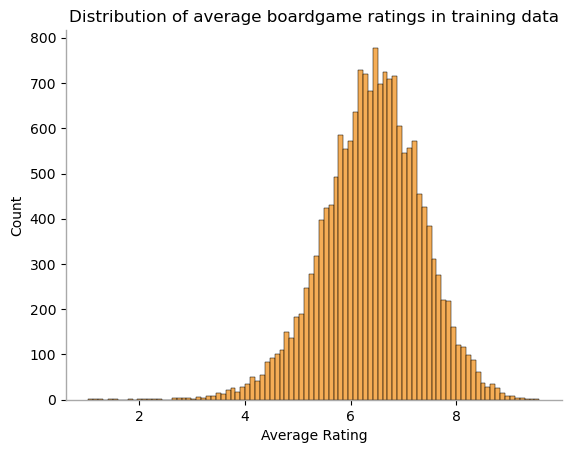

In [66]:
with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0}):
    p1 = sns.histplot(data = training_data, x = "average", color = "#F2921D").set(
        title = "Distribution of average boardgame ratings in training data",
        xlabel = "Average Rating")


### Other variables

The dataset comes in two files, *ratings.csv* and *details.csv*. In both files, a row corresponds to a single board game, so the two files can be easily merged. The table below summarizes the number of observations in the training and test sets.

In [29]:
n_train_ratings = len(training_data)
n_test_ratings = len(test_data)

train_details = training_data.merge(details, on = "id")
n_train_w_details = len(train_details)
test_details = test_data.merge(details, on = "id")
n_test_w_details = len(test_details)

n_obs_table = pd.DataFrame({
    "Table" : ["Training (ratings)", "Training (details)", "Test (ratings)", "Test (details)"],
    "Number of observations": [n_train_ratings, n_train_w_details, n_test_ratings, n_test_w_details]
})
n_obs_table


,Table,Number of observations
0,Training (ratings),17464
1,Training (details),17311
2,Test (ratings),4367
3,Test (details),4320


In [30]:
train_details["test"] = 0
test_details["test"] = 1
combined_details = pd.concat([train_details, test_details], axis = 0)

Next, let's plot average rating as a function of various potential features (`yearpublished`, `minplayers`, `maxplayers`, `playingtime`, and designer and publisher variables).

### Number of players

We will treat the player-number features as categorical, since they are small and integer-valued.

The plot below shows the distribution of games by minimum player count, as well as average ratings by minimum player count. A minimum player count of 1 seems to be associated with higher average ratings than a minimum player count of 2: presumably players value the ability to play a game in "solo" mode.

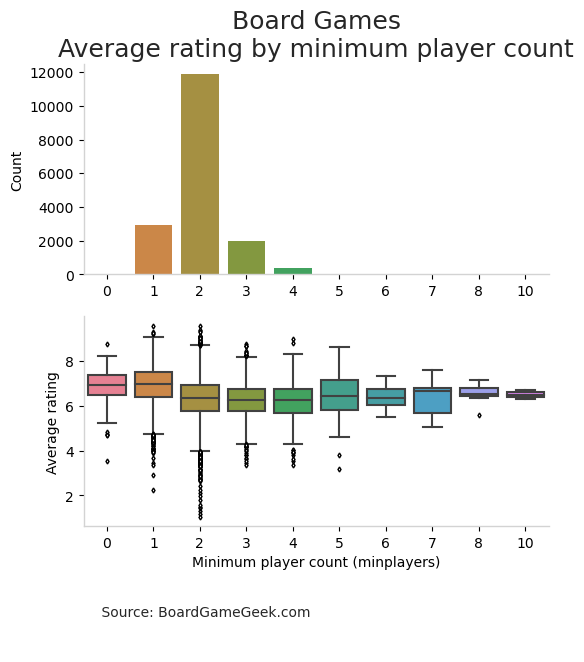

In [79]:

flierprops = dict(marker='d',
                  markerfacecolor='white',
                  markeredgecolor = 'black',
                  markersize=2.5)
palette = sns.color_palette("husl", 11)

with mpl.rc_context({'text.color': '.15',
                    'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'lightgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': '.15'}):
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax = ax.flatten()
    
    p1 = sns.countplot(ax = ax[0], data = train_details, x = "minplayers",
                      palette = palette)
    p2 = sns.boxplot(ax = ax[1],
                     data = train_details,
                     x = "minplayers",
                     y = "average",
                     flierprops = flierprops,
                     palette = palette)
    temp = p1.set(title = "Boardgames\nAverage rating by minimum player count",
                  xlabel = "",
                  ylabel = "Count")
    temp = p2.set(title = "",
                  xlabel = "Minimum player count (minplayers)",
                  ylabel = "Average rating")

    footnote_text = f"""
    Source: BoardGameGeek.com
    
    """
    ax[1].annotate(footnote_text, xy = (0.0, -.3), xycoords = "axes fraction", ha = "left", va = "top")


The plot below shows the distribution of games by *maximum* player count, as well as average ratings by maximum player count. Unsurprisingly, even max player counts are more common than odd max player counts. However, there seems to be a small premium associated with even max player counts: games with a max player count of 5 and 7 haveslightly higher average ratings than games with max player counts of 4 and 6, respectively. It is unclear why this should be the case but one possible explanation is that games max player counts of 5 and 7 are associated with more thoughtfulness in the game's design.

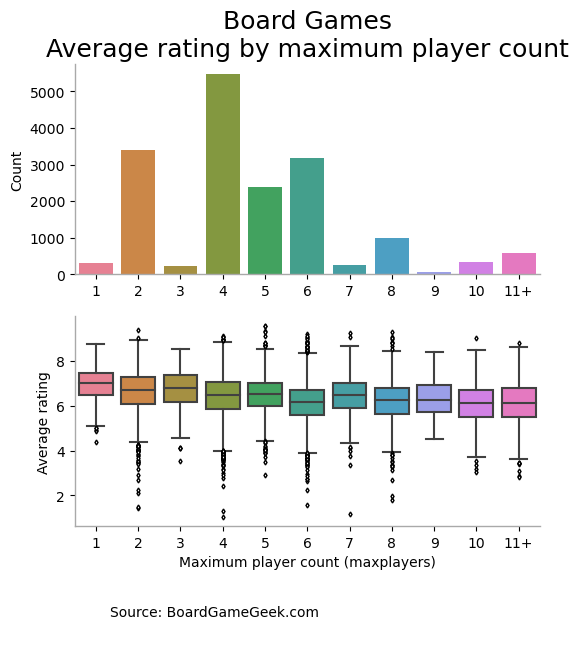

In [81]:


train_details_plot = train_details.copy()
train_details_plot["maxplayers"] = train_details["maxplayers"].apply(lambda x: str(x) if x <= 10 else "11+")

factor_order = [str(i) for i in range(1,11)] + ["11+"]

palette = sns.color_palette("husl", 11)

with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': 'black'}):
    
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax = ax.flatten()

    p1 = sns.countplot(ax = ax[0], data = train_details_plot, x = "maxplayers", order = factor_order, palette = palette)
    p2 = sns.boxplot(ax = ax[1], data = train_details_plot,
                     x = "maxplayers",
                     y = "average",
                     order = factor_order, 
                     palette = palette,
                    flierprops = flierprops)
    temp = p1.set(title = "Boardgames\nAverage rating by maximum player count", xlabel = "", ylabel = "Count")
    temp = p2.set(title = "", xlabel = "Maximum player count (maxplayers)", ylabel = "Average rating")
    
    footnote_text = f"""
        Source: BoardGameGeek.com

        """
    ax[1].annotate(footnote_text, xy = (0.0, -.3), xycoords = "axes fraction", ha = "left", va = "top")

### Playing time

Next, let's look at the playing time for each game.

The plot below shows the distribution of playing times, as well as the average rating by playing time. The bins below *include* their right-most edges, e.g., the "0-30 mins" bin includes games with a playing time of 30 minutes.

The plot shows that longer games have higher average ratings, on average. This is presumably not a *direct* causal effect (i.e., doubling a game's play time does not make it better automatically). Rather, it is likely a combination of two things: (i) a longer play time allows a game to be more complex and more complex games are better on average (at least up to a point); and (ii) in a kind of selection effect, longer games are less accessible (on average) and therefore only *high quality* long games end up getting published.


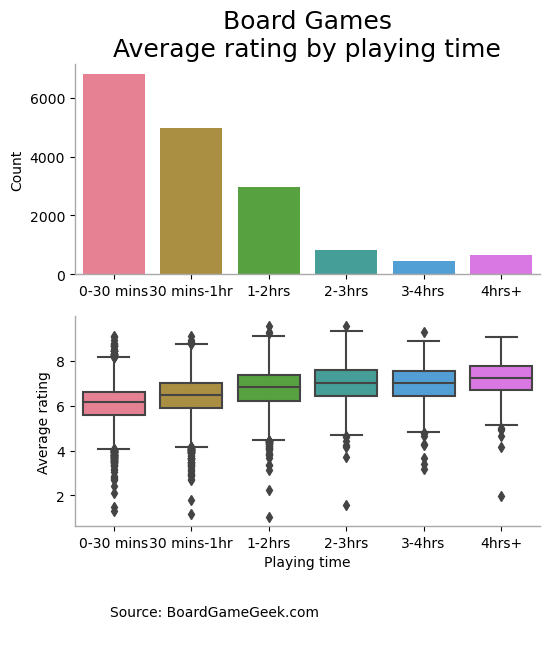

In [82]:
train_details_plot = train_details.copy()
train_details_plot["playingtime_binned"] = pd.cut(train_details_plot["playingtime"],
                                                 bins = [0, 30, 60, 120, 180, 240, np.inf],
                                                 labels = ["0-30 mins", "30 mins-1hr", "1-2hrs", "2-3hrs", "3-4hrs", "4hrs+"],
                                                 right = True)

with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': 'black'}):
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax = ax.flatten()

    p1 = sns.countplot(ax = ax[0], 
                  data = train_details_plot, 
                  x = "playingtime_binned", 
                  palette = sns.color_palette("husl", 6))
    p2 = sns.boxplot(ax = ax[1], 
                data = train_details_plot, 
                x = "playingtime_binned", 
                y = "average", 
                palette = sns.color_palette("husl", 6))
    temp = p1.set(title = "Board Games\nAverage rating by playing time",
          xlabel = "", ylabel = "Count")
    temp = p2.set(title = "", xlabel = "Playing time", ylabel = "Average rating")
    
    footnote_text = f"""
        Source: BoardGameGeek.com

        """
    ax[1].annotate(footnote_text, xy = (0.0, -.3), xycoords = "axes fraction", ha = "left", va = "top")



### Year published

For simplicity, I bin the year published variable before plotting. There is no particular reason to think that any one year is all that different from neighboring years.

The plot below shows the distribution by decade/five year period of publication, as well as the average rating by the same time published bins.

As the plot shows, more recent games tend to have higher ratings. This pattern should not necessarily be interpreted to mean that modern games are better in any objective sense than older games. That may be true, but the same pattern may also arise if more modern games simply appeal more to modern reviewers, since the rating data is (broadly speaking) a snapchat of modern reviewers' preferences. The pattern may also reflect a preference for newness: for example, it is possible that reviewers give higher scores to games that are new *to them* (and which they are therefore excited to play), which translates to newer games getting higher scores on average.

Incidentally, the plot also illustrates the explosion in boardgame publishing over the past 20 years or so. Over twice as many games were published in the years 2015-19 as were published in the entire 1990s.


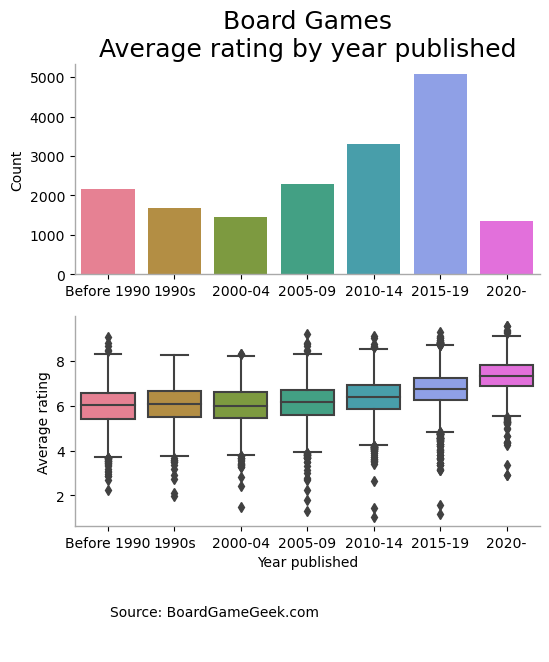

In [83]:

plot_data = train_details.copy()

plot_data["yearpublished_cat"] = pd.cut(plot_data["yearpublished"], right = False,
       bins = [-np.inf, 1990, 2000, 2005, 2010, 2015, 2020, np.inf],
       labels = ["Before 1990", "1990s", "2000-04", "2005-09", "2010-14", "2015-19", "2020-"])

with mpl.rc_context({'grid.linestyle': ':',
                    'axes.facecolor': 'white',
                    'grid.color': 'lightgray',
                    'axes.spines.bottom': True,
                     'axes.spines.left' : True,
                     'axes.spines.top' : False,
                     'axes.spines.right' : False,
                    'axes.edgecolor': 'darkgray',
                    'axes.linewidth': 1.0,
                    'axes.titlesize': 18,
                    'axes.titlecolor': 'black'}):
    fig, ax = plt.subplots(2, 1, figsize=(6,6))
    ax = ax.flatten()

    p1 = sns.countplot(ax = ax[0], 
                  data = plot_data, 
                  x = "yearpublished_cat", 
                  palette = sns.color_palette("husl", 7))
    p2 = sns.boxplot(ax = ax[1],
                     data = plot_data,
                     x = "yearpublished_cat",
                     y = "average",
                     palette = sns.color_palette("husl", 7))
    temp = p1.set(title = "Board Games\nAverage rating by year published",
          xlabel = "", ylabel = "Count")
    temp = p2.set(title = "", xlabel = "Year published", ylabel = "Average rating")
    
    footnote_text = f"""
        Source: BoardGameGeek.com

        """
    ax[1].annotate(footnote_text, xy = (0.0, -.3), xycoords = "axes fraction", ha = "left", va = "top")


### Mechanics, Designers, and Publishers

The dataset includes data on the mechanics (e.g., "Dice rolling," "Auctions/Bidding") used in each boardgame. Games are typically associated with multiple mechanics, so values in the "mechanics" field in *details.csv* are comma-separated lists of mechanics, which we have to preprocess before plotting. There are 149 different unique mechanics in the BGG dataset. What constitutes a unique "mechanic" (and for any given mechanic, whether a board game uses that mechanic or not) may be a matter of disagreement between users. The mechanics data is populated (at least in part) by users of the site. I take the data as is.

The plot below shows the average rating deviation for the 30 most commonly used mechanics (ranked in descending order of deviation). The plot shows that board games with certain mechanics have (on average) higher average ratings than the overall average rating, while board games with other mechanics have lower average ratings. It is interesting to see the mechanics associated with higher and lower average ratings: some mechanics associated with what are sometimes to referred as "Euro"-style games (worker placement, action points, and, to a lesser extent, solo and cooperative play) have higher average ratings, while certain mechanics associated with chance and player conflict and interaction ("Roll / Spin and Move," "Trading," and "Player Elimination") have lower average ratings.

Note that we have already observed the premium associated with "Solo / Solitaire Game," since it presumably is highly correlated with minimum player count of 1.

In [49]:
# split mechanics
import re

def split_out_column(df, col_name, prefix = "cat_", category_threshold = 0):

  def increment_cat_dict(s): # find all unique entries (and create a dict counting the number of games having each mechanic)
    if not isinstance(s, str):
      return

    if s[1] == "'": # entries are either of the ["xx", "yy", ...] or ['xx', 'yy', ...]
      s = re.sub('"', "", s)
      s = s.replace("\\", "") # ignore escaping
      categories = re.findall(r"'([^']+)'", s)
    else:
      s = re.sub("'", "", s)
      s = s.replace("\\", "")
      categories = re.findall(r'"([^"]+)"', s)
    

    for category in categories:  
      if category in cat_dict:
        cat_dict[category] += 1
      else:
        cat_dict[category] = 1

  cat_dict = {}
  df[col_name].apply(increment_cat_dict)

  # Add columns for each dict
  new_df = df.copy()
  for category in cat_dict:

    if cat_dict[category] > category_threshold:
      new_col_name = prefix + category
      new_df[new_col_name] = new_df[col_name].str.contains(category)
      new_df[new_col_name] = pd.to_numeric(new_df[new_col_name], errors = 'coerce', downcast = "integer")

  return new_df


In [50]:
train_details_mech = split_out_column(train_details, "boardgamemechanic", prefix = "mech_", category_threshold = 15)

C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [51]:
# find the most common mechanics
# find most common mechs
mech_cols = [x for x in train_details_mech.columns if x.startswith("mech_")]

mech_counts = {}
for col in mech_cols:
  total = train_details_mech[col].sum()
  mech_counts[col] = total

mech_counts_df = pd.DataFrame.from_dict(data = mech_counts, orient = "index", columns = ["count"]).sort_values("count", ascending = False)

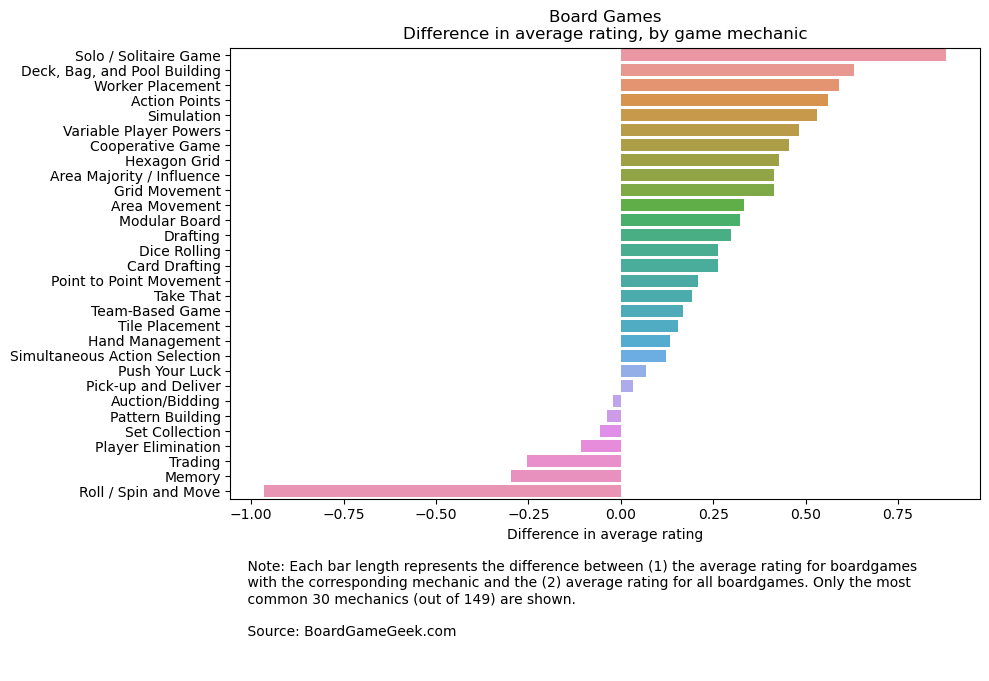

In [101]:
n_mechanics = len(mech_counts_df)

topX_mechs = mech_counts_df[:30]

all_groupbys = pd.DataFrame({"present":[],
                             "average":[],
                             "mech":[]})

overall_average = np.mean(train_details["average"])

for i, mech in enumerate(topX_mechs.index):
  mech = topX_mechs.index[i]
  mech_groupby = train_details_mech.groupby(mech).aggregate(np.mean)["average"].reset_index()
  mech_groupby["mech"] = mech
  mech_groupby = mech_groupby.rename(columns = {mech: "present"})
  all_groupbys = pd.concat([all_groupbys, mech_groupby], axis = 0)

all_groupbys = all_groupbys[all_groupbys["present"] == 1.0].drop(columns = "present")
all_groupbys["diff_average"] = all_groupbys["average"] - overall_average
all_groupbys["mech"] = all_groupbys["mech"].apply(lambda x: re.split("mech_", x)[1])
all_groupbys = all_groupbys.sort_values("diff_average", ascending = False)
#print(all_groupbys.sort_values("diff_average"))

fig, ax = plt.subplots(figsize = (10, 7))
p1 = sns.barplot(data = all_groupbys, y = "mech", x = "diff_average")
p1.set(title = "Board Games\nDifference in average rating, by game mechanic",
      xlabel = "Difference in average rating",
      ylabel = "")

footnote_text = f"""
    Note: Each bar length represents the difference between (1) the average rating for boardgames
    with the corresponding mechanic and the (2) average rating for all boardgames. Only the most 
    common 30 mechanics (out of {n_mechanics}) are shown.
    
    Source: BoardGameGeek.com
    
"""
ax.annotate(footnote_text, xy = (0.0, -.1), xycoords = "axes fraction", ha = "left", va = "top")
fig.tight_layout()

### Designers

We will treat designers as we did mechanics: a board game may have multiple designers, so we split out the "designer" variable, and create dummy variables indicating whether a board game was designed by a particular designer or not. Because there are so many distinct designers in the dataset, we only include designers with at least 10 design credits.

The plot below shows the average rating deviation, by designer, for the twenty designers with the largest (positive) average rating deviations. All of these designers have designed (or co-designed) at least 10 games in the dataset and their games are more highly rated than board games overall. For example, [Hermann Luttman](https://boardgamegeek.com/boardgamedesigner/36105/hermann-luttmann/linkeditems/boardgamedesigner?pageid=1), designer of 33 games, has a postive average rating difference of almost 1.4 (out of 10).

In [102]:
train_details_designer = split_out_column(train_details,
                                          "boardgamedesigner",
                                          prefix = "dsgnr_",
                                          category_threshold = 10)

C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[new_col_name] = new_df[col_name].str.contains(category)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_75980\3285797091.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [103]:
designers = [x for x in train_details_designer if x.startswith("dsgnr_")]

all_groupbys = pd.DataFrame({"present":[],
                             "average":[],
                             "cat":[]})

overall_average = np.mean(train_details["average"])

for i, col_name in enumerate(designers):
  cat_groupby = train_details_designer.groupby(col_name).aggregate(np.mean)["average"].reset_index()
  cat_groupby["cat"] = col_name
  cat_groupby = cat_groupby.rename(columns = {col_name: "present"})
  
  #print(cat_groupby)

  all_groupbys = pd.concat([all_groupbys, cat_groupby], axis = 0)

all_groupbys = all_groupbys[all_groupbys["present"] == 1.0].drop(columns = "present")
all_groupbys["diff_average"] = all_groupbys["average"] - overall_average
all_groupbys["cat"] = all_groupbys["cat"].apply(lambda x: re.split("dsgnr_", x)[1])
all_groupbys = all_groupbys.sort_values("diff_average", ascending = False)



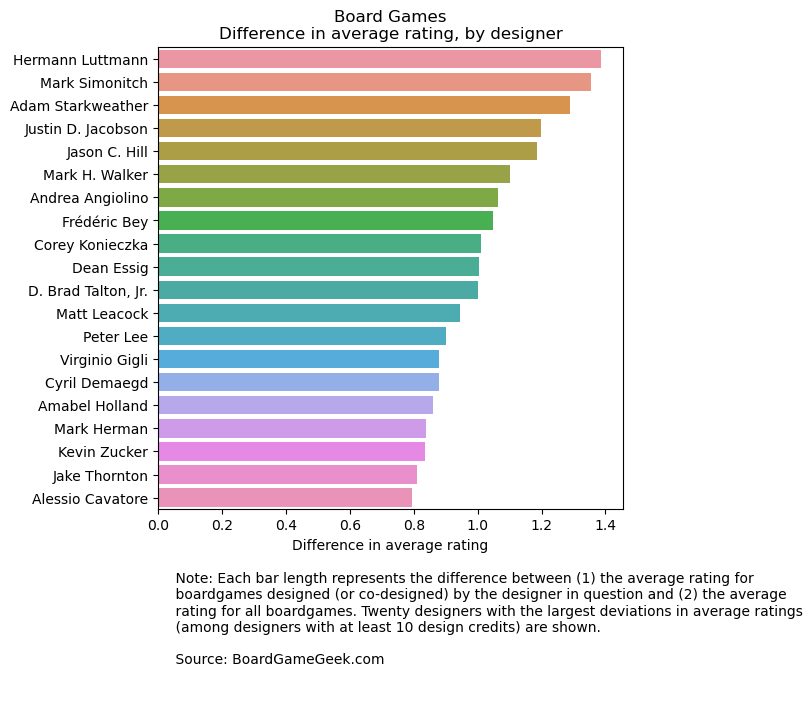

In [110]:
fig, ax = plt.subplots(figsize = (6, 6))
p1 = sns.barplot(data = all_groupbys[:20], y = "cat", x = "diff_average")
temp = p1.set(title = "Board Games\nDifference in average rating, by designer",
      xlabel = "Difference in average rating",
      ylabel = "")

footnote_text = f"""
    Note: Each bar length represents the difference between (1) the average rating for 
    boardgames designed (or co-designed) by the designer in question and (2) the average 
    rating for all boardgames. Twenty designers with the largest deviations in average ratings
    (among designers with at least 10 design credits) are shown.
    
    Source: BoardGameGeek.com
    
"""
temp = ax.annotate(footnote_text, xy = (0.0, -.1), xycoords = "axes fraction", ha = "left", va = "top")

### Publishers

With the "publisher" variable, we will take a different approach.

Using all the data we have on a boardgame's publisher in our modeling step risks contaminating the predictive analysis. This is because the exercise we have in mind is to predict a boardgame's average rating based on *intrinsic characteristics* of the game, and thus we want to avoid using as predictor any variables that are not intrinsic to the game. Because successful games are likely to be published multiple times (via revised editions and other-language editions), the set of publishers associated with a boardgame is not intrinsic to the game and instead depends, at least in part, on how successful a boardgame has been.

Ideally, we would want to use data on a boardgame's *first* publisher only, since the exercise we have in mind would allow us to observe the game's *first* publisher before making our rating prediction. However, the *boardgamepublisher* variable includes only a list of publishers and does not provide any way (as far as I can see) to identify a game's first publisher. To approximate using the first publisher, we will use data on a single *randomly chosen* publisher per game. Because there are far too many publishers in the dataset to deal with, for modeling and visualization, we will only retain publishers associated with at least 10 boardgames.

In [111]:
def reduce_multiple_entries(x):
  if not isinstance(x, str) or len(x) < 3:
    return ""

  if x[1] == "'":
    entries = re.findall(r"'([^']+)'", x)
  else:
    entries = re.findall(r'"([^"]+)"', x)
  
  if len(entries):
    return entries[np.random.randint(len(entries))] # if many, return random
  else:
    print(x)
    return ""

def clean_and_otherize_list_entry(s, threshold):
  # first reduce multiples
  s_new = s.apply(reduce_multiple_entries)

  # otherize publishers with < theshold entries
  s_counts = s_new.value_counts()
  small_entries = s_counts[s_counts < threshold].index.array
  s_new = s_new.apply(lambda x: "Other" if x in small_entries else x)

  return s_new

In [114]:
publisher_threshold = 10

publisher_clean = clean_and_otherize_list_entry(train_details["boardgamepublisher"], publisher_threshold)

#print(publisher_clean.value_counts()) # 313 distinct publishers

train_details_pub = train_details.copy()
train_details_pub["publisher_clean"] = publisher_clean

In [117]:
top_30_publishers = publisher_clean.value_counts()[:30].index.values

plot_data = train_details_pub[train_details_pub["publisher_clean"].isin(top_30_publishers)]





In [118]:
by_pub = plot_data.groupby(["publisher_clean"])["average"].agg(np.mean)
by_pub = by_pub.sort_values(ascending = False)
factor_order = by_pub.index


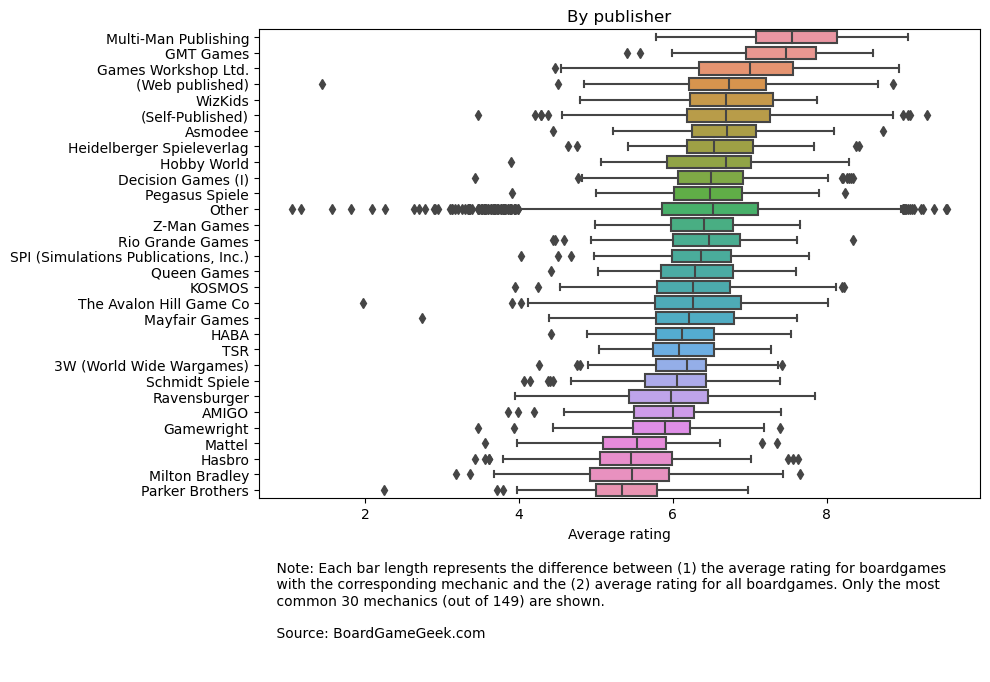

In [120]:

fig, ax = plt.subplots(figsize = (10, 7))


#p1 = sns.histplot(data = plot_data[plot_data["publisher_clean"] != "Other"], y = "publisher_clean")
p1 = sns.boxplot(data = plot_data, y = "publisher_clean", x = "average", order = factor_order)
temp = p1.set(title = "By publisher",
      xlabel = "Average rating",
      ylabel = "")

footnote_text = f"""
    Note: Each bar length represents the difference between (1) the average rating for boardgames
    published by the corresponding publisher and (2) the average rating for all boardgames. For boardgames 
    with 
    
    Source: BoardGameGeek.com
    
"""
temp = ax.annotate(footnote_text, xy = (0.0, -.1), xycoords = "axes fraction", ha = "left", va = "top")
fig.tight_layout()

### Conclusion

Based on our visualizations, it seems that at least some of the features will help us predict average ratings. We will continue with the modeling in the Part 2.